In [1]:
import pybedtools as pbt
import pysam
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.linear_model import LinearRegression
import csv
from keras.models import load_model
from pkg_resources import resource_filename
from spliceai.utils import one_hot_encode
from maxentpy import maxent
from collections import Counter
import itertools
import matplotlib

Using TensorFlow backend.


In [2]:
import altair as alt
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [3]:
import os.path as op

In [4]:
import seaborn as sns

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import splanl.junction_scorer as jn
import splanl.merge_bcs as mbcs
import splanl.coords as cds
import splanl.plots as sp
import splanl.score_motifs as sm
import splanl.inspect_variants as iv
import splanl.post_processing as pp
import splanl.custom_splai_scores as css
import splanl.create_vcf as vcf

In [7]:
matplotlib.rc_file_defaults()
plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.rcParams[ 'font.sans-serif' ] = "Arial"
plt.rcParams[ 'font.family' ] = "sans-serif"

In [8]:
chr11 = '/nfs/kitzman3/lab_common/refs/human/ucsc_hg19/bychrom/chr11.fa'
chr11_seq = pp.get_refseq( chr11 )[ 0 ]

In [9]:
fa_file = '/nfs/kitzman2/jacob/proj/jensplice/20220415_wt1_mpsa_trial3/jkp1053_1054_1055.fa'
refseq = pp.get_refseq( fa_file )[ 0 ]

In [10]:
github_colors = '3182bd6baed69ecae1c6dbefe6550dfd8d3cfdae6bfdd0a231a35474c476a1d99bc7e9c0756bb19e9ac8bcbddcdadaeb636363969696bdbdbdd9d9d9'

In [11]:
light_colors = [ '#' + github_colors[i:i+6] for i in range( 0, len( github_colors ), 6 ) ]

In [43]:
plot_out = '/nfs/kitzman2/smithcat/proj/wt1_2022/plots/'

In [12]:
bdout = '/nfs/kitzman2/smithcat/proj/wt1_2022/ex9_data/'

In [13]:
byvartbl_long = pd.read_table( bdout + 'wt1_ex9_by_var_effects_snvs-2022-0721.txt' )

In [14]:
byvartbl_wide = pd.read_table( bdout + 'wt1_ex9_by_var_effects_snvs_wide-2022-0722.txt' )

In [15]:
byvartbl_wide = mbcs.create_variables_across_samples( byvartbl_wide,
                                                 [ samp for samp in byvartbl_long[ 'sample' ].unique() ],
                                                 mean_cols = [ 'n_bc','n_bc_passfilt', 'sum_reads','sum_reads_passfilt', ],
                                                 median_cols = [ 'n_bc','n_bc_passfilt', 'sum_reads','sum_reads_passfilt', ],
                                                 sum_cols = [ 'sum_reads','sum_reads_passfilt', ],
                                                 max_cols = [ 'n_bc','n_bc_passfilt', 'sum_reads','sum_reads_passfilt', ] )

In [16]:
byvartbl_wide = mbcs.compute_bc_weighted_psi( byvartbl_wide,
                                         [ samp for samp in byvartbl_long[ 'sample' ].unique() ],
                                         [ 'KTS+','KTS-','SKIP','OTHER' ],
                                         'n_bc_passfilt',
                              )

In [17]:
byvartbl_wide[ 'KTS_+_ratio' ] = byvartbl_wide[ 'wmean_KTS+' ] / byvartbl_wide[ 'wmean_KTS-' ]

In [18]:
byvartbl_wide[ 'KTS_+_ratio' ].min()

0.14295248998906002

In [19]:
byvartbl_wide[ 'KTS_+_ratio' ].max()

7.821890747379142

In [20]:
byvartbl_wide[ 'KTS_+_ratio_log2' ] = np.log2( byvartbl_wide[ 'KTS_+_ratio' ] )

In [21]:
byvartbl_wide[ 'KTS_+_ratio_log2' ].min()

-2.8063923454074544

In [22]:
byvartbl_wide[ 'KTS_+_ratio_log2' ].max()

2.9675173853018633

In [62]:
for col in [ 'wmean_KTS+', 'wmean_KTS-', 'wmean_SKIP', 'wmean_OTHER', 'DS_maxm', 'ss_don_prob_32413527', 'ss_don_prob_32413518' ]:
    
    byvartbl_wide[ col + '_100' ] = byvartbl_wide[ col ]*100

In [63]:
byvartbl_wide_sat = pp.saturate_variants( byvartbl_wide,
                                         chr11_seq,
                                         'hg19_pos',
                                          'exon_num',
                                          rev_strand = True )[ 9 ]

In [64]:
#plots get messed up without the vector position included
byvartbl_wide_sat[ 'pos' ] = byvartbl_wide_sat.hg19_pos - 32412079 - 2*( byvartbl_wide_sat.hg19_pos - byvartbl_wide_sat.hg19_pos.min() )

In [65]:
byvartbl_wide_sat[ 'hgvs_pos' ] = cds.pos_to_hgvspos( byvartbl_wide_sat.pos,
                                                     ( 1058, 1554 ),
                                                    [ (1267, 1359) ],
                                                    [ ( 1355, 1447 ), ]
                                                    )

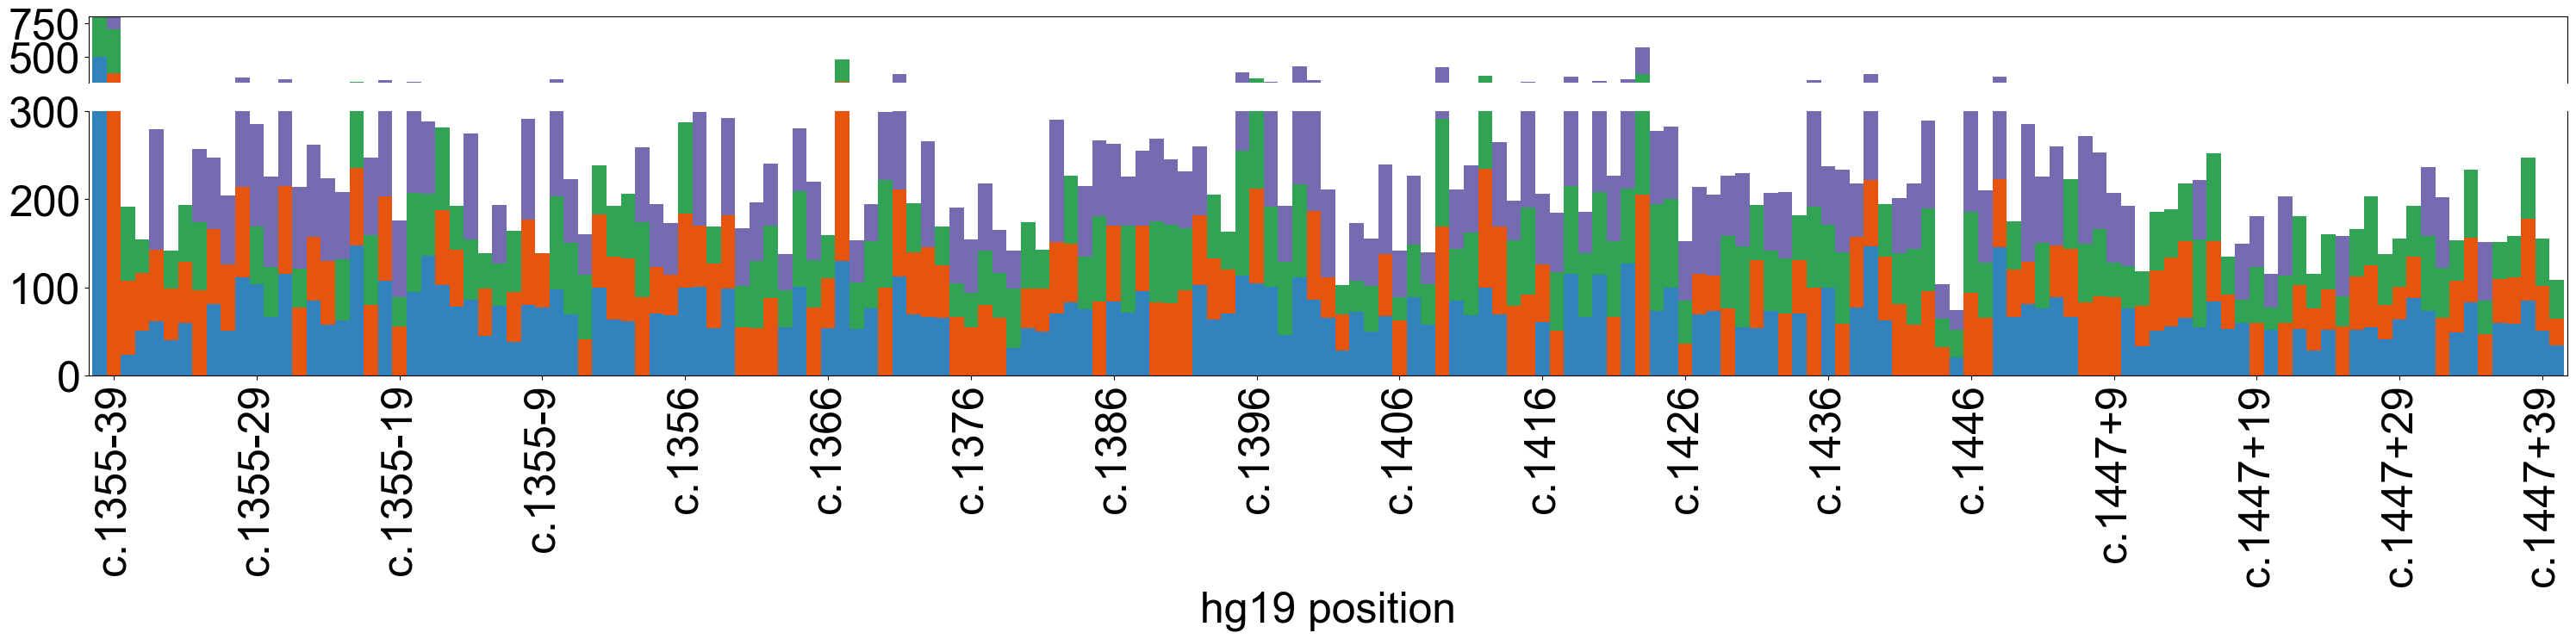

In [27]:
sp.split_ax_bcs(  byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                  [ 'n_bc_passfilt_mean' ],
                  'hgvs_pos',
                    [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                    [ ( 300.5, 800 ), ( 0, 300 ) ],
                    fig_size = ( 30, 7.5 ),
                    legend = False,
                    hratios = [ 1, 4 ],
                    x_ax_title = 'cDNA position',
                    #tight = False,
                    #savefile = plot_out + 'bcs_filt_by_pos_split.pdf'
                           )

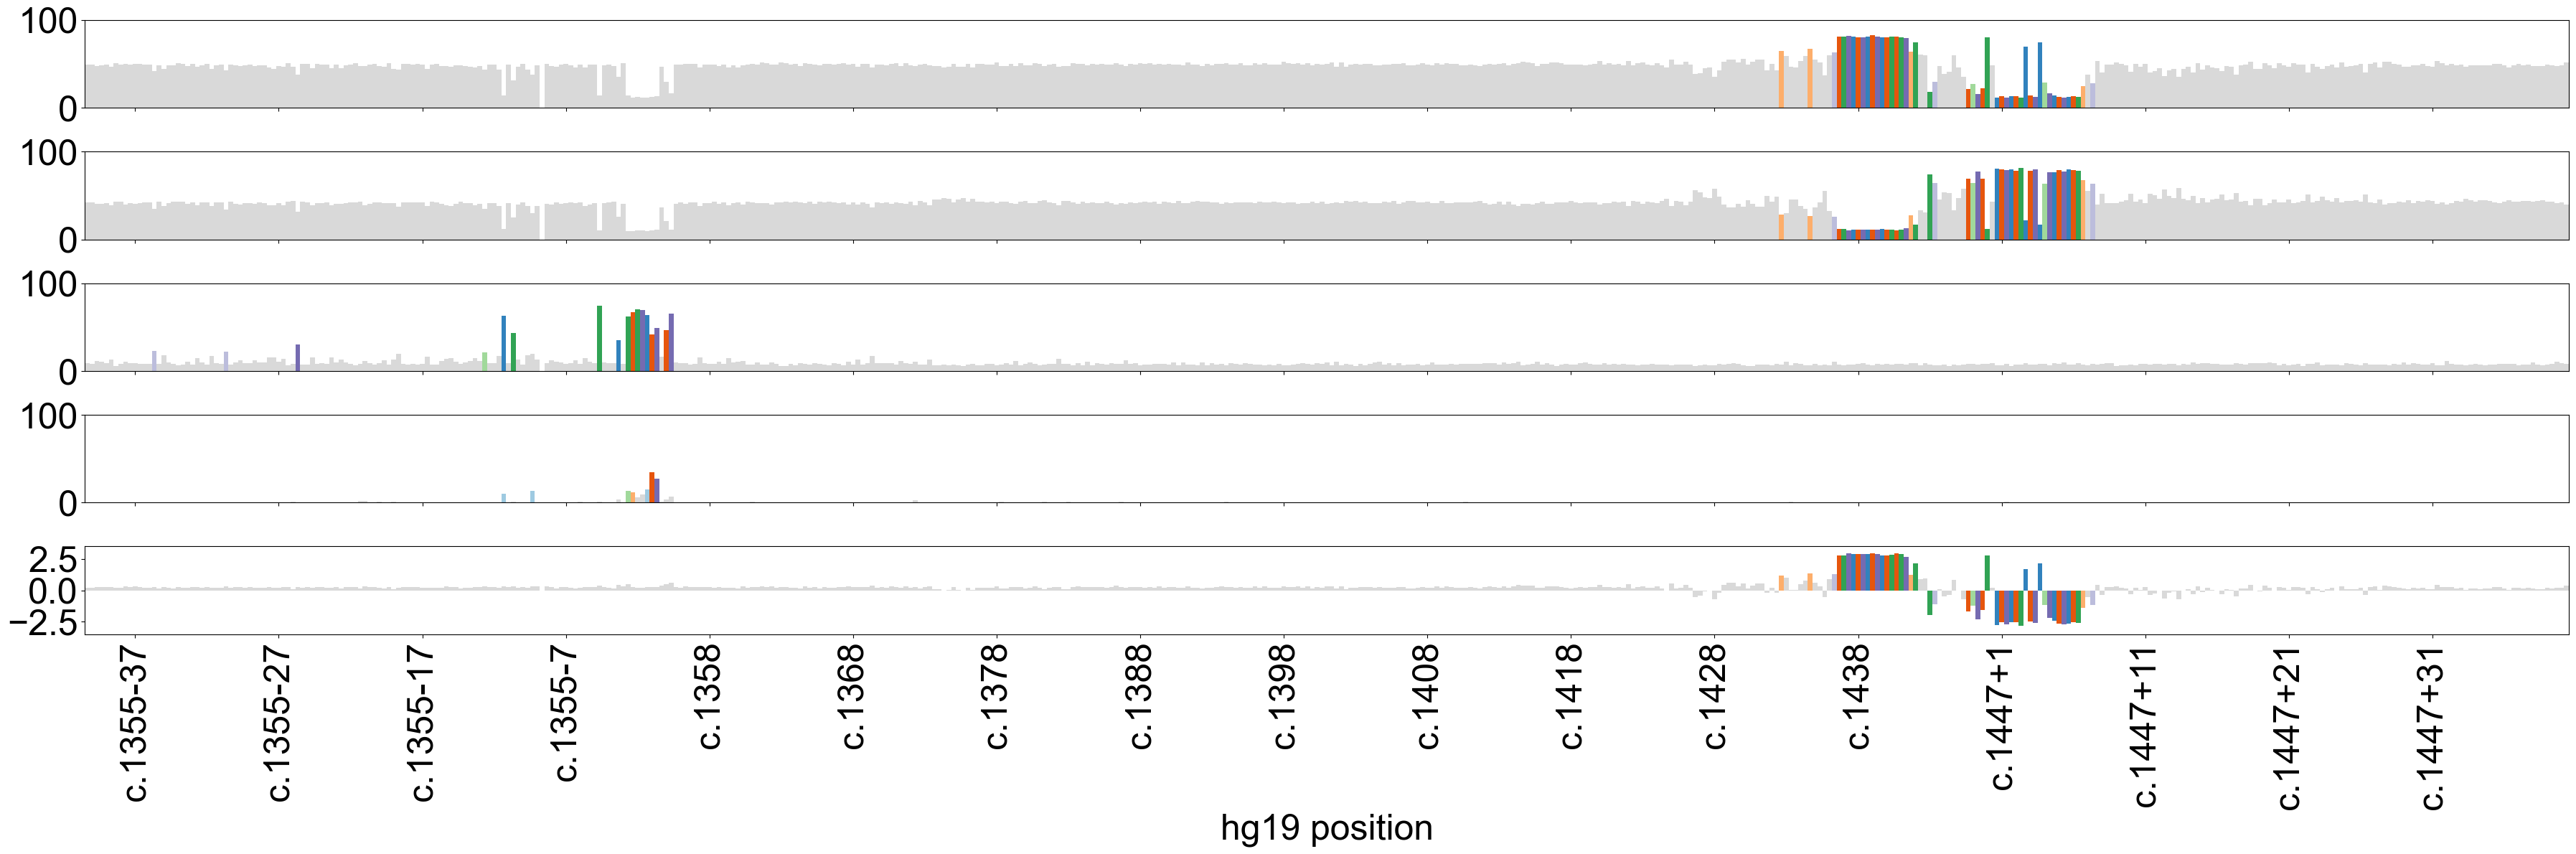

In [50]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                         [ 'wmean_KTS+_100', 'wmean_KTS-_100', 'wmean_SKIP_100', 'wmean_OTHER_100', 'KTS_+_ratio_log2' ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 36, 12 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( 0, 100 ), ( 0, 100 ), ( -3.5, 3.5 ) ],
                          y_ax_title = [ '', '', '', '', '' ], 
                          x_ax_title = 'cDNA position',
                          tick_spacing = 10,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

In [53]:
acc_plot = [ 'wmean_SKIP_100', 'wmean_OTHER_100', 'maxent_acc', 'DS_maxm_100' ]

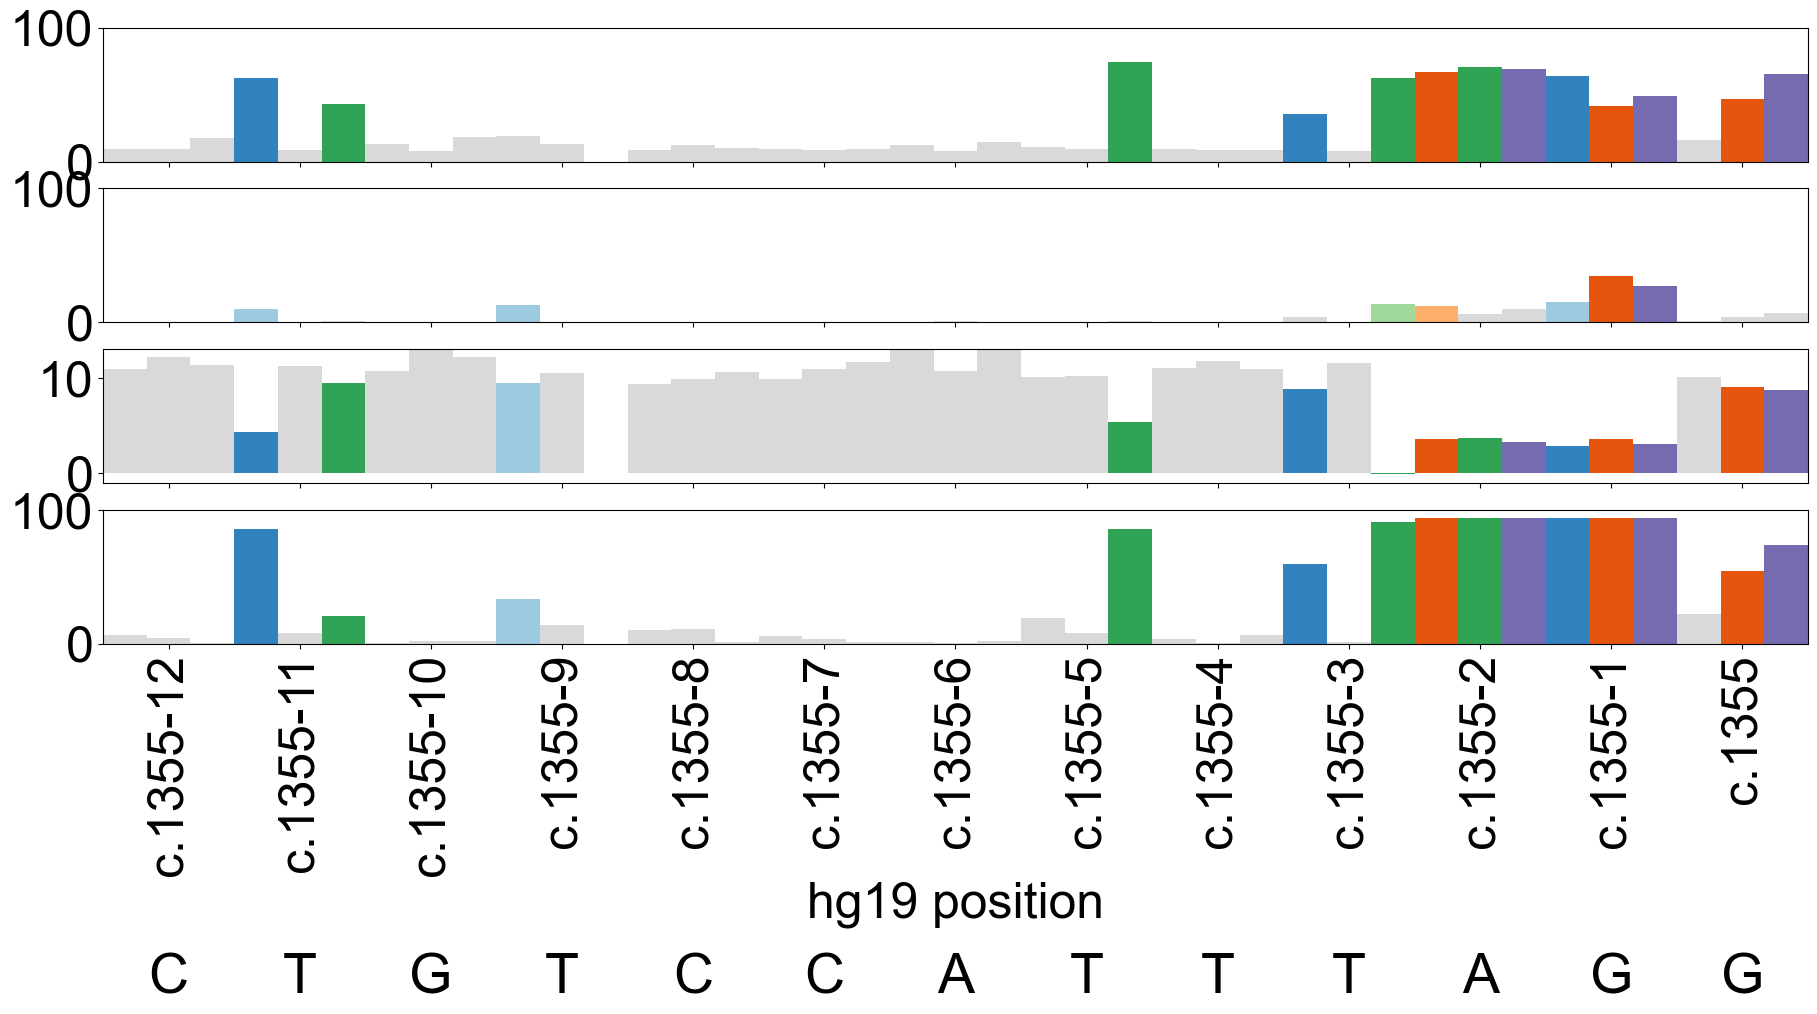

In [61]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          acc_plot,
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          zoom = ( 1255, 1267 ),
                          fig_size = ( 22, 8 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), ],
                          darken_bars2 = [ ( 'sdv_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( -1, 13 ), ( 0, 100 ), ],
                          y_ax_title = [ '' ]*len( acc_plot ),
                          x_ax_title = 'cDNA position',
                          tick_spacing = 1,
                          ref_labels = True,
                          y_ref_cds = -250,
                          tight = False,
                          savefile = plot_out + 'acc_zoom.pdf'
                     )

In [31]:
byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1255 ) & ( byvartbl_wide.pos <= 1267 ) & ( byvartbl_wide.lit_interp.notnull() ) ]

,hgvs_pos,hg19_pos,ref,alt,ref_c,alt_c,pos,chrom,varlist,exon_num,...,Reference from HGMD,Note,clinvar,acmg,lit_interp,KTS_+_ratio_log2,wmean_KTS+_100,wmean_KTS-_100,wmean_SKIP_100,wmean_OTHER_100
399,c.1355-1,32413611,C,T,G,A,1266,11,jkp815:1266:G:A,9,...,"Kanemoto (2007) Pediatr Nephrol 22, 454","Although not reported in ClinVar, it was repor...",False,True,Lit_LPP,0.256781,11.508028,9.631679,63.932414,14.904771
419,c.1355-7,32413617,G,A,C,T,1260,11,jkp815:1260:C:T,9,...,NaN,NaN,True,True,LBB,0.198550,48.414564,42.189714,9.373850,0.353039
422,c.1355-8,32413618,G,A,C,T,1259,11,jkp815:1259:C:T,9,...,NaN,NaN,True,True,LBB,0.149580,47.023191,42.392007,10.417028,0.389861
426,c.1355-10,32413620,C,G,G,C,1257,11,jkp815:1257:G:C,9,...,NaN,NaN,True,True,LBB,0.267248,50.377054,41.858434,7.605339,0.414703


In [105]:
byvartbl_wide.loc[ ( byvartbl_wide.pos <= 1280 ) ].sdv.sum()

14

In [66]:
kts_neg_plot = [ 'wmean_KTS+_100', 'wmean_KTS-_100', 'KTS_+_ratio_log2', 'maxent_KTS-', 'DS_maxm_100', 'ss_don_prob_32413527_100', ]

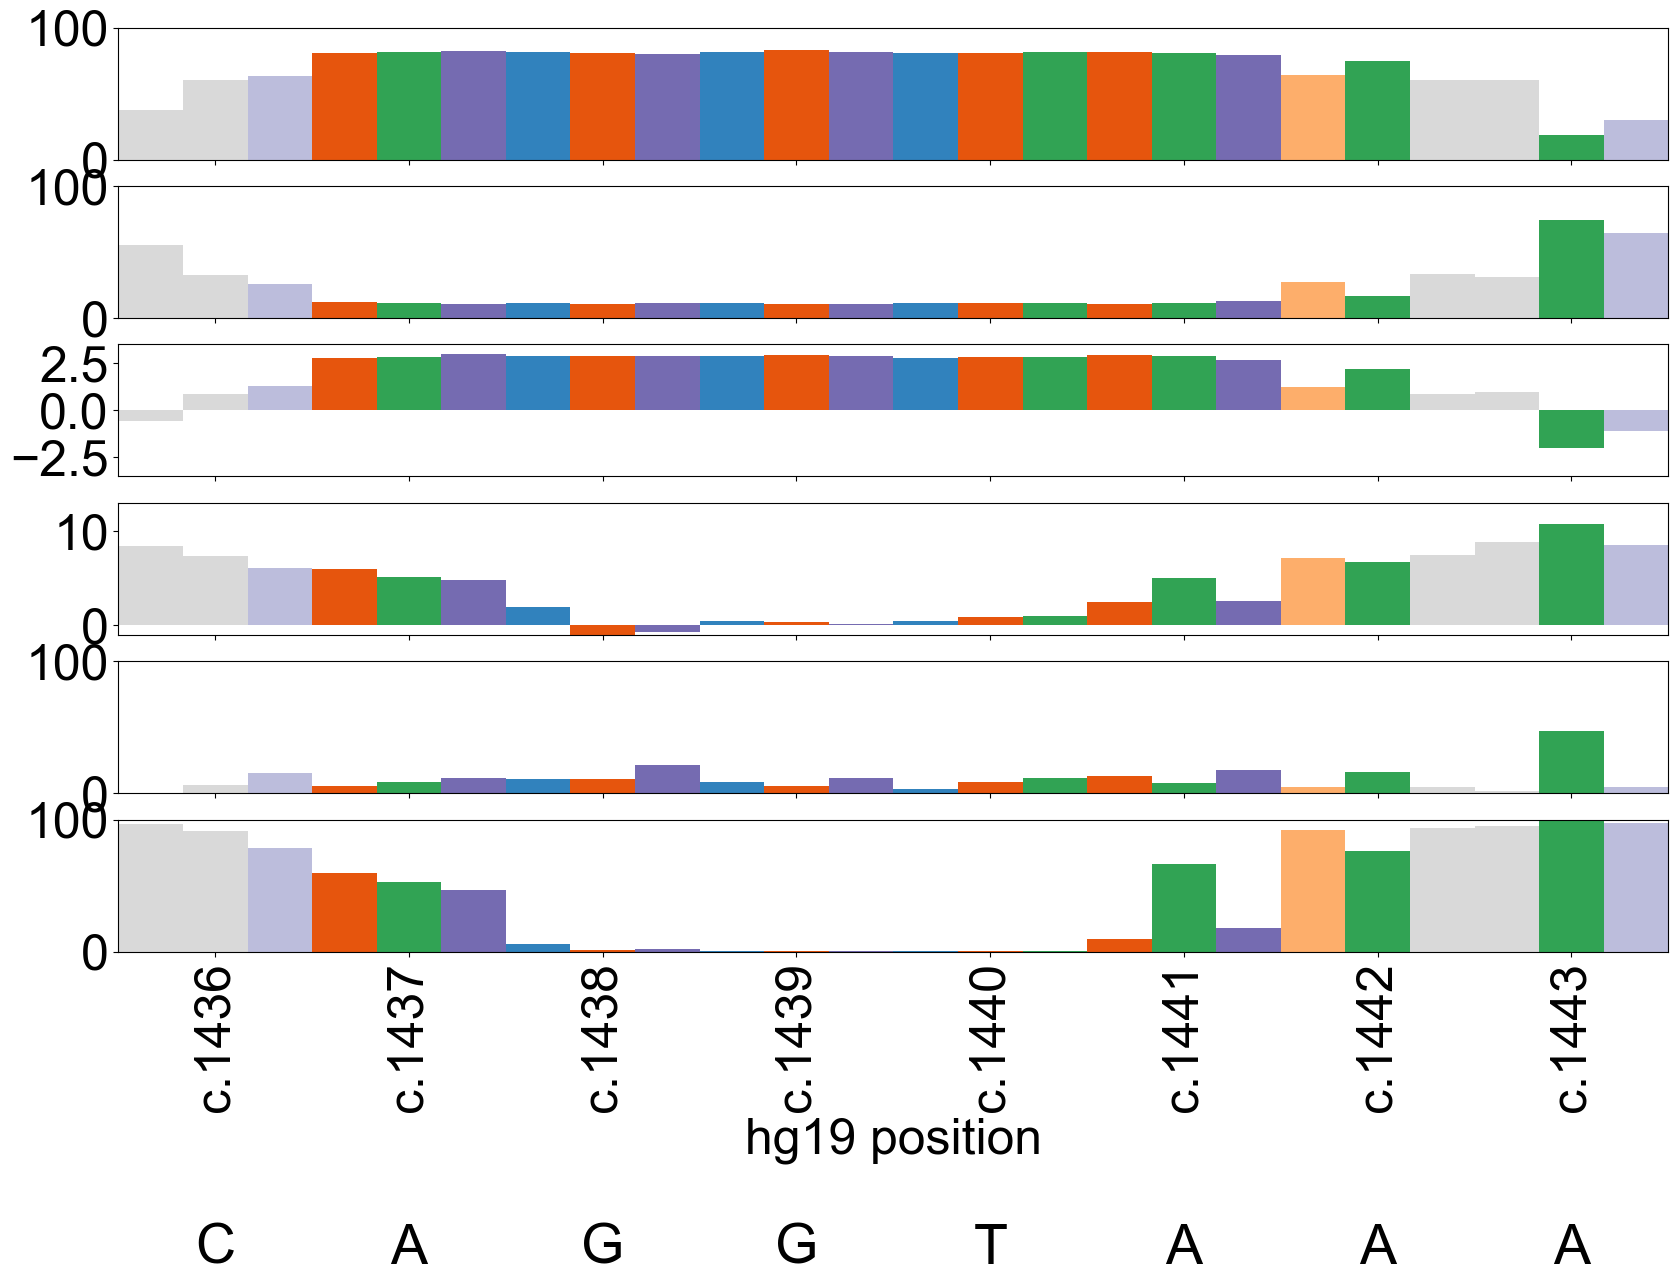

In [72]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          kts_neg_plot,
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          zoom = ( 1348, 1355 ),
                          fig_size = ( 20, 12 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                           ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                           ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( -3.5, 3.5 ), ( -1, 13 ), ( 0, 100 ), ( 0, 100 ) ],
                          y_ax_title = [ '' ]*len( kts_neg_plot ),
                          x_ax_title = 'cDNA position',
                          tick_spacing = 1,
                          ref_labels = True,
                          y_ref_cds = -225,
                          tight = False,
                          savefile = plot_out + 'kts-_zoom.pdf'
                     )

In [97]:
byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1348 ) & ( byvartbl_wide.pos <= 1355 ) & ( byvartbl_wide.lit_interp.notnull() ) ]

,hgvs_pos,hg19_pos,ref,alt,ref_c,alt_c,pos,chrom,varlist,exon_num,...,Reference from HGMD,Note,clinvar,acmg,lit_interp,KTS_+_ratio_log2,wmean_KTS+_100,wmean_KTS-_100,wmean_SKIP_100,wmean_OTHER_100
151,c.1437,32413528,T,C,A,G,1349,11,jkp815:1349:A:G,9,...,NaN,NaN,True,False,Conflicting,2.805321,81.107852,11.60318,6.861348,0.521705


In [74]:
kts_pos_plot = [ 'wmean_KTS+_100', 'wmean_KTS-_100', 'KTS_+_ratio_log2', 'maxent_KTS+', 'DS_maxm_100', 'ss_don_prob_32413518_100', ]

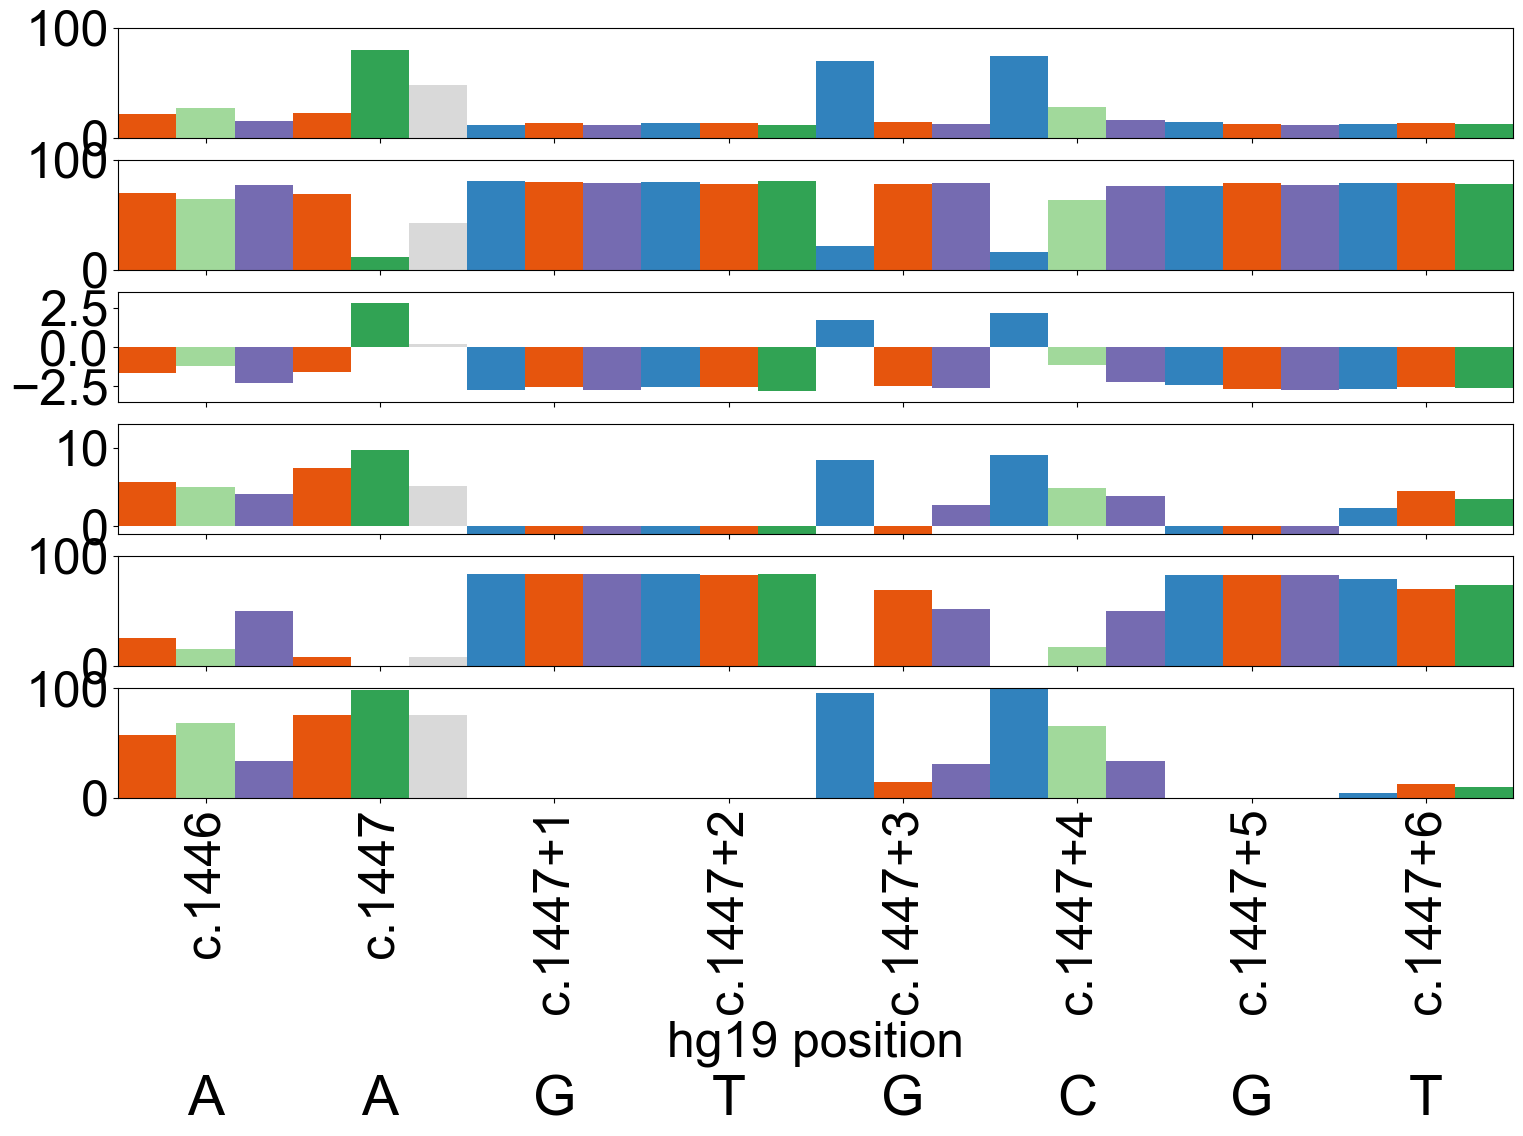

In [87]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          kts_pos_plot,
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          zoom = ( 1358, 1365 ),
                          fig_size = ( 18, 10 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                           ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                           ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( -3.5, 3.5 ), ( -1, 13 ), ( 0, 100 ), ( 0, 100 ) ],
                          y_ax_title = [ '' ]*len( kts_pos_plot ),
                          x_ax_title = 'cDNA position',
                          tick_spacing = 1,
                          ref_labels = True,
                          y_ref_cds = -275,
                          tight = False,
                          savefile = plot_out + 'kts+_zoom.pdf'
                     )

In [92]:
byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1358 ) & ( byvartbl_wide.pos <= 1365 ) & ( byvartbl_wide.lit_interp.notnull() ) ]

,hgvs_pos,hg19_pos,ref,alt,ref_c,alt_c,pos,chrom,varlist,exon_num,...,acmg,lit_interp,KTS_+_ratio_log2,wmean_KTS+_100,wmean_KTS-_100,wmean_SKIP_100,wmean_OTHER_100,DS_maxm_100,ss_don_prob_32413527_100,ss_don_prob_32413518_100
102,c.1447+6,32413512,A,T,T,A,1365,11,jkp815:1365:T:A,9,...,True,LPP,-2.647929,12.688233,79.525620,7.639198,0.216104,79.126179,97.108811,4.114395
105,c.1447+5,32413513,C,T,G,A,1364,11,jkp815:1364:G:A,9,...,True,LPP,-2.416018,14.356231,76.618614,8.915593,0.439724,83.027709,97.993594,0.212867
107,c.1447+5,32413513,C,A,G,T,1364,11,jkp815:1364:G:T,9,...,True,Lit_LPP,-2.712676,11.850800,77.686337,10.091601,0.465967,83.135086,98.543626,0.105488
110,c.1447+4,32413514,G,A,C,T,1363,11,jkp815:1363:C:T,9,...,True,LPP,-2.196374,16.758837,76.810094,6.509733,0.258271,49.864733,97.976398,33.375841
111,c.1447+3,32413515,C,T,G,A,1362,11,jkp815:1362:G:A,9,...,True,VUS,1.702866,69.857534,21.458506,8.637117,0.404015,0.220591,94.685620,95.071185
113,c.1447+3,32413515,C,A,G,T,1362,11,jkp815:1362:G:T,9,...,True,Lit_LPP,-2.621125,12.925564,79.521883,7.577361,0.254969,52.059984,98.188460,31.180587
115,c.1447+2,32413516,A,G,T,C,1361,11,jkp815:1361:T:C,9,...,True,LPP,-2.520973,13.668076,78.450558,7.779899,0.394238,83.051550,98.053598,0.189026
117,c.1447+1,32413517,C,T,G,A,1360,11,jkp815:1360:G:A,9,...,True,Lit_LPP,-2.753503,11.966772,80.698242,6.908826,0.579344,83.221596,98.082924,0.018977
118,c.1447+1,32413517,C,G,G,C,1360,11,jkp815:1360:G:C,9,...,True,Lit_LPP,-2.552222,13.632323,79.958596,6.334742,0.330469,83.238488,98.274958,0.002086


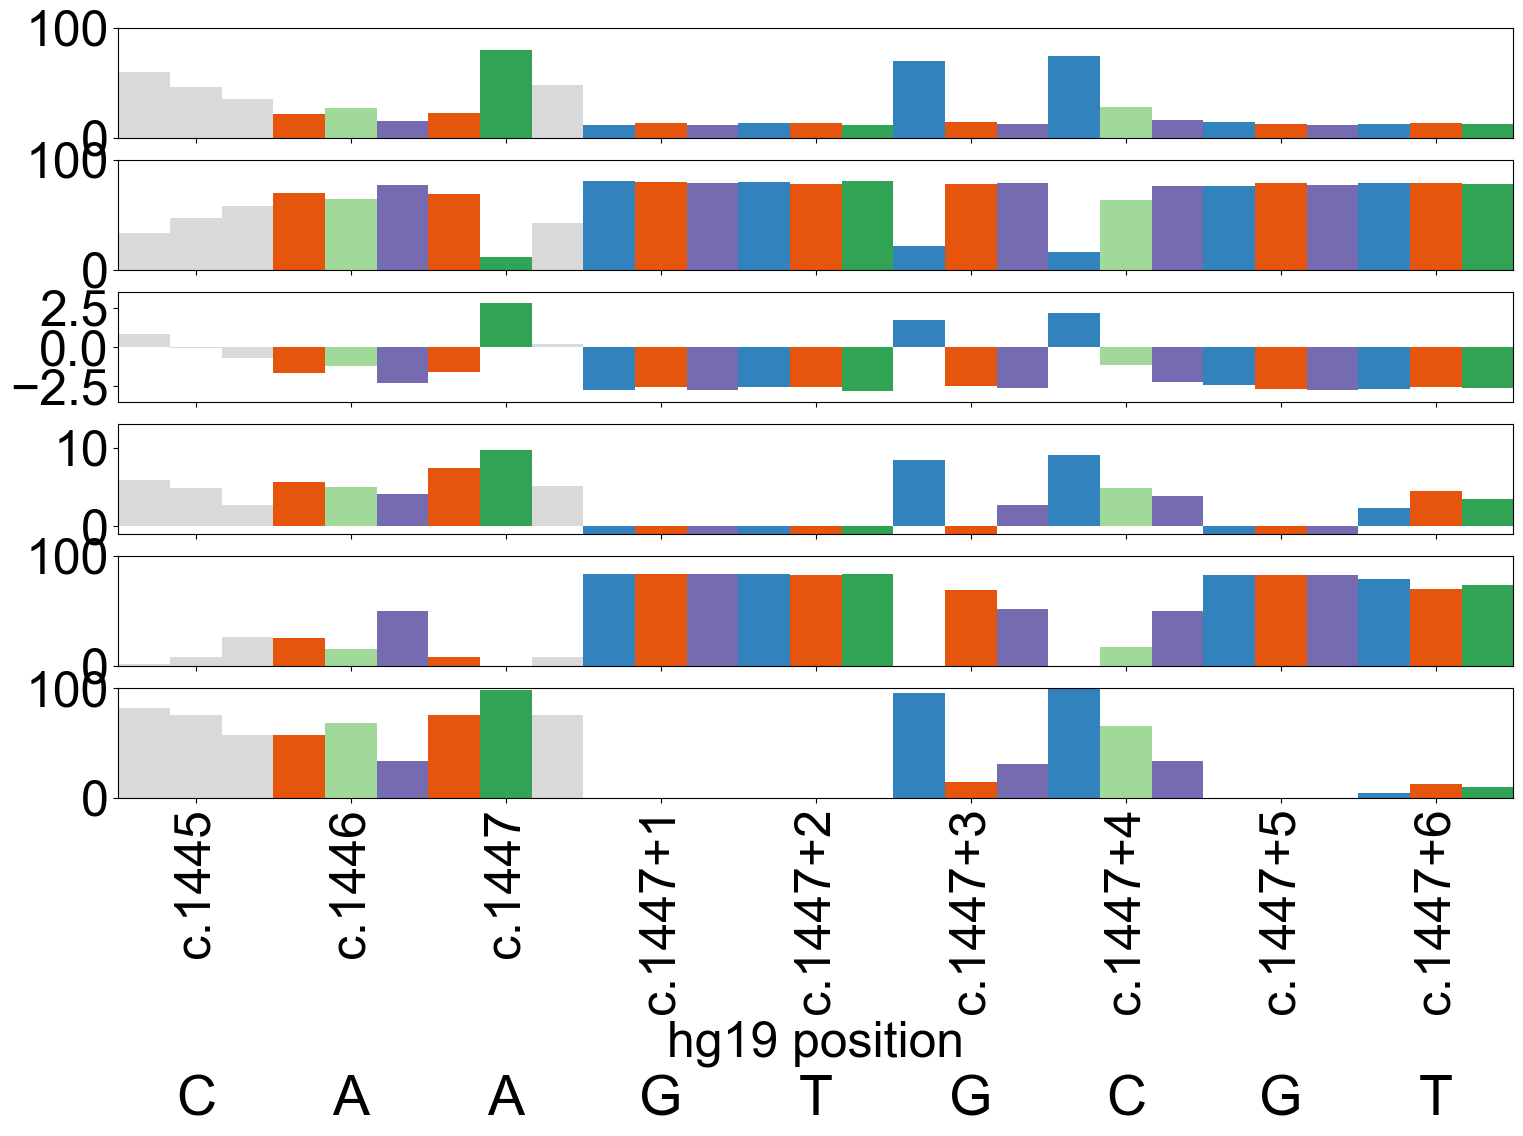

In [90]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          kts_pos_plot,
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          zoom = ( 1357, 1365 ),
                          fig_size = ( 18, 10 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                           ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                           ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( -3.5, 3.5 ), ( -1, 13 ), ( 0, 100 ), ( 0, 100 ) ],
                          y_ax_title = [ '' ]*len( kts_pos_plot ),
                          x_ax_title = 'cDNA position',
                          tick_spacing = 1,
                          ref_labels = True,
                          y_ref_cds = -275,
                          tight = False,
                          savefile = plot_out + 'kts+_zoom2.pdf'
                     )

In [91]:
byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1357 ) & ( byvartbl_wide.pos <= 1365 ) & ( byvartbl_wide.lit_interp.notnull() ) ]

,hgvs_pos,hg19_pos,ref,alt,ref_c,alt_c,pos,chrom,varlist,exon_num,...,acmg,lit_interp,KTS_+_ratio_log2,wmean_KTS+_100,wmean_KTS-_100,wmean_SKIP_100,wmean_OTHER_100,DS_maxm_100,ss_don_prob_32413527_100,ss_don_prob_32413518_100
102,c.1447+6,32413512,A,T,T,A,1365,11,jkp815:1365:T:A,9,...,True,LPP,-2.647929,12.688233,79.525620,7.639198,0.216104,79.126179,97.108811,4.114395
105,c.1447+5,32413513,C,T,G,A,1364,11,jkp815:1364:G:A,9,...,True,LPP,-2.416018,14.356231,76.618614,8.915593,0.439724,83.027709,97.993594,0.212867
107,c.1447+5,32413513,C,A,G,T,1364,11,jkp815:1364:G:T,9,...,True,Lit_LPP,-2.712676,11.850800,77.686337,10.091601,0.465967,83.135086,98.543626,0.105488
110,c.1447+4,32413514,G,A,C,T,1363,11,jkp815:1363:C:T,9,...,True,LPP,-2.196374,16.758837,76.810094,6.509733,0.258271,49.864733,97.976398,33.375841
111,c.1447+3,32413515,C,T,G,A,1362,11,jkp815:1362:G:A,9,...,True,VUS,1.702866,69.857534,21.458506,8.637117,0.404015,0.220591,94.685620,95.071185
113,c.1447+3,32413515,C,A,G,T,1362,11,jkp815:1362:G:T,9,...,True,Lit_LPP,-2.621125,12.925564,79.521883,7.577361,0.254969,52.059984,98.188460,31.180587
115,c.1447+2,32413516,A,G,T,C,1361,11,jkp815:1361:T:C,9,...,True,LPP,-2.520973,13.668076,78.450558,7.779899,0.394238,83.051550,98.053598,0.189026
117,c.1447+1,32413517,C,T,G,A,1360,11,jkp815:1360:G:A,9,...,True,Lit_LPP,-2.753503,11.966772,80.698242,6.908826,0.579344,83.221596,98.082924,0.018977
118,c.1447+1,32413517,C,G,G,C,1360,11,jkp815:1360:G:C,9,...,True,Lit_LPP,-2.552222,13.632323,79.958596,6.334742,0.330469,83.238488,98.274958,0.002086


In [99]:
byvartbl_wide.sdv.sum()

52

In [100]:
byvartbl_wide.sdv.sum() / len( byvartbl_wide )

0.10038610038610038

In [88]:
byvartbl_wide.intmed.sum()

13

In [89]:
byvartbl_wide.intmed.sum() / len( byvartbl_wide )

0.025096525096525095

In [95]:
kts_plot = [ 'wmean_KTS+_100', 'wmean_KTS-_100', 'KTS_+_ratio_log2', 'maxent_KTS-', 'maxent_KTS+', 'DS_maxm_100', 'ss_don_prob_32413527_100', 'ss_don_prob_32413518_100', ]

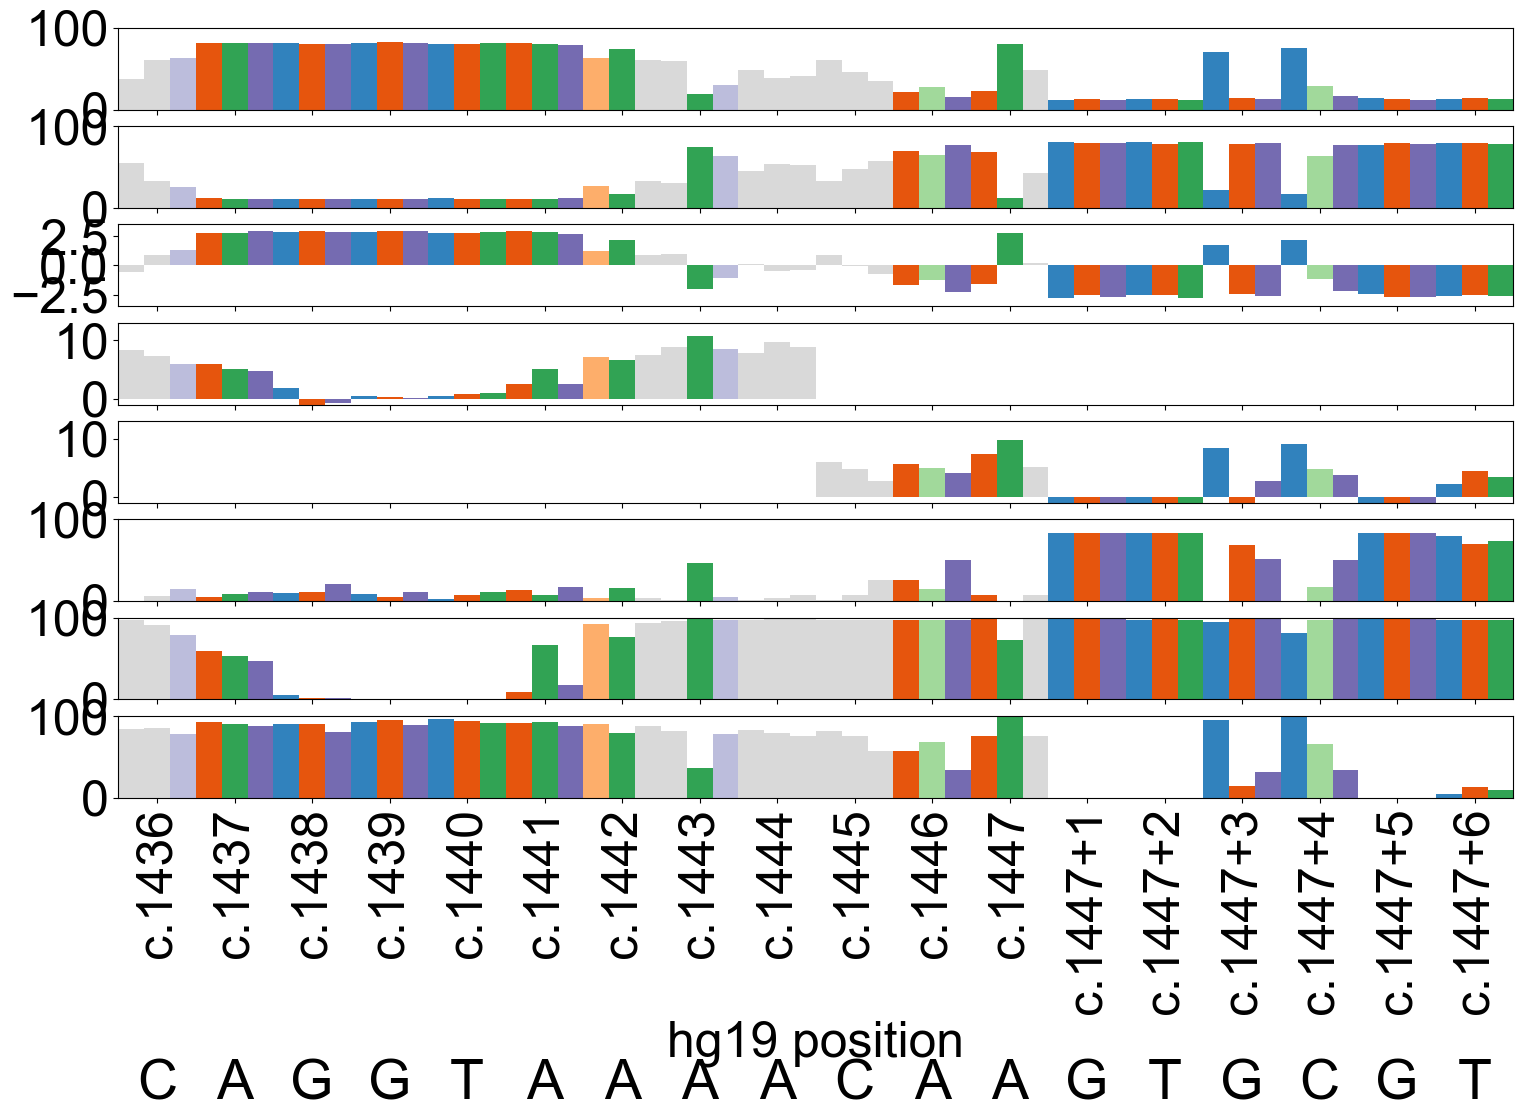

In [97]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          kts_plot,
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          zoom = ( 1348, 1365 ),
                          fig_size = ( 18, 10 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                           ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                           ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( -3.5, 3.5 ), ( -1, 13 ), ( -1, 13 ), ( 0, 100 ), ( 0, 100 ), ( 0, 100 ) ],
                          y_ax_title = [ '' ]*len( kts_plot ),
                          x_ax_title = 'cDNA position',
                          tick_spacing = 1,
                          ref_labels = True,
                          y_ref_cds = -350,
                          tight = False,
                          savefile = plot_out + 'kts_comb_zoom.pdf'
                     )

In [98]:
byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1348 ) & ( byvartbl_wide.pos <= 1365 ) & ( byvartbl_wide.lit_interp.notnull() ) ]

,hgvs_pos,hg19_pos,ref,alt,ref_c,alt_c,pos,chrom,varlist,exon_num,...,acmg,lit_interp,KTS_+_ratio_log2,wmean_KTS+_100,wmean_KTS-_100,wmean_SKIP_100,wmean_OTHER_100,DS_maxm_100,ss_don_prob_32413527_100,ss_don_prob_32413518_100
102,c.1447+6,32413512,A,T,T,A,1365,11,jkp815:1365:T:A,9,...,True,LPP,-2.647929,12.688233,79.525620,7.639198,0.216104,79.126179,97.108811,4.114395
105,c.1447+5,32413513,C,T,G,A,1364,11,jkp815:1364:G:A,9,...,True,LPP,-2.416018,14.356231,76.618614,8.915593,0.439724,83.027709,97.993594,0.212867
107,c.1447+5,32413513,C,A,G,T,1364,11,jkp815:1364:G:T,9,...,True,Lit_LPP,-2.712676,11.850800,77.686337,10.091601,0.465967,83.135086,98.543626,0.105488
110,c.1447+4,32413514,G,A,C,T,1363,11,jkp815:1363:C:T,9,...,True,LPP,-2.196374,16.758837,76.810094,6.509733,0.258271,49.864733,97.976398,33.375841
111,c.1447+3,32413515,C,T,G,A,1362,11,jkp815:1362:G:A,9,...,True,VUS,1.702866,69.857534,21.458506,8.637117,0.404015,0.220591,94.685620,95.071185
113,c.1447+3,32413515,C,A,G,T,1362,11,jkp815:1362:G:T,9,...,True,Lit_LPP,-2.621125,12.925564,79.521883,7.577361,0.254969,52.059984,98.188460,31.180587
115,c.1447+2,32413516,A,G,T,C,1361,11,jkp815:1361:T:C,9,...,True,LPP,-2.520973,13.668076,78.450558,7.779899,0.394238,83.051550,98.053598,0.189026
117,c.1447+1,32413517,C,T,G,A,1360,11,jkp815:1360:G:A,9,...,True,Lit_LPP,-2.753503,11.966772,80.698242,6.908826,0.579344,83.221596,98.082924,0.018977
118,c.1447+1,32413517,C,G,G,C,1360,11,jkp815:1360:G:C,9,...,True,Lit_LPP,-2.552222,13.632323,79.958596,6.334742,0.330469,83.238488,98.274958,0.002086
151,c.1437,32413528,T,C,A,G,1349,11,jkp815:1349:A:G,9,...,False,Conflicting,2.805321,81.107852,11.603180,6.861348,0.521705,8.698803,52.829593,89.634705


In [101]:
byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1357 ) & ( byvartbl_wide.pos <= 1365 ) ].sdv.sum()

21

In [102]:
byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1348 ) & ( byvartbl_wide.pos <= 1355 ) ].sdv.sum()

17

In [123]:
byvartbl_wide.loc[ byvartbl_wide.pos == 1352 ]

,hgvs_pos,hg19_pos,ref,alt,ref_c,alt_c,pos,chrom,varlist,exon_num,...,KTS_+_ratio_log2,wmean_KTS+_100,wmean_KTS-_100,wmean_SKIP_100,wmean_OTHER_100,DS_maxm_100,ss_don_prob_32413527_100,ss_don_prob_32413518_100,incr_KTS+,incr_KTS-
141,c.1440,32413525,A,T,T,A,1352,11,jkp815:1352:T:A,9,...,2.792071,80.757904,11.659716,7.441467,0.272808,3.048021,0.000580,96.685040,True,False
142,c.1440,32413525,A,G,T,C,1352,11,jkp815:1352:T:C,9,...,2.806065,80.366258,11.491164,8.123705,0.187647,8.119971,0.081499,93.513882,True,False
143,c.1440,32413525,A,C,T,G,1352,11,jkp815:1352:T:G,9,...,2.843219,81.360294,11.337530,7.285850,0.360674,11.598337,0.003409,91.546285,True,False


In [124]:
byvartbl_wide[ 'sdv_ss' ] = ( byvartbl_wide.sdv ) \
                            & ( ( byvartbl_wide.pos == 1265 ) | ( byvartbl_wide.pos == 1266 ) \
                                | ( byvartbl_wide.pos == 1351 ) | ( byvartbl_wide.pos == 1352 ) \
                                | ( byvartbl_wide.pos == 1360 ) | ( byvartbl_wide.pos == 1361 ) ) 

In [115]:
byvartbl_wide[ 'incr_KTS+' ] = ( byvartbl_wide.pos >= 1340 ) & ( byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ] ) & ( byvartbl_wide[ 'KTS_+_ratio_log2' ] > 0 )

In [116]:
byvartbl_wide[ 'incr_KTS-' ] = ( byvartbl_wide.pos >= 1340 ) & ( byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ] ) & ( byvartbl_wide[ 'KTS_+_ratio_log2' ] < 0 )

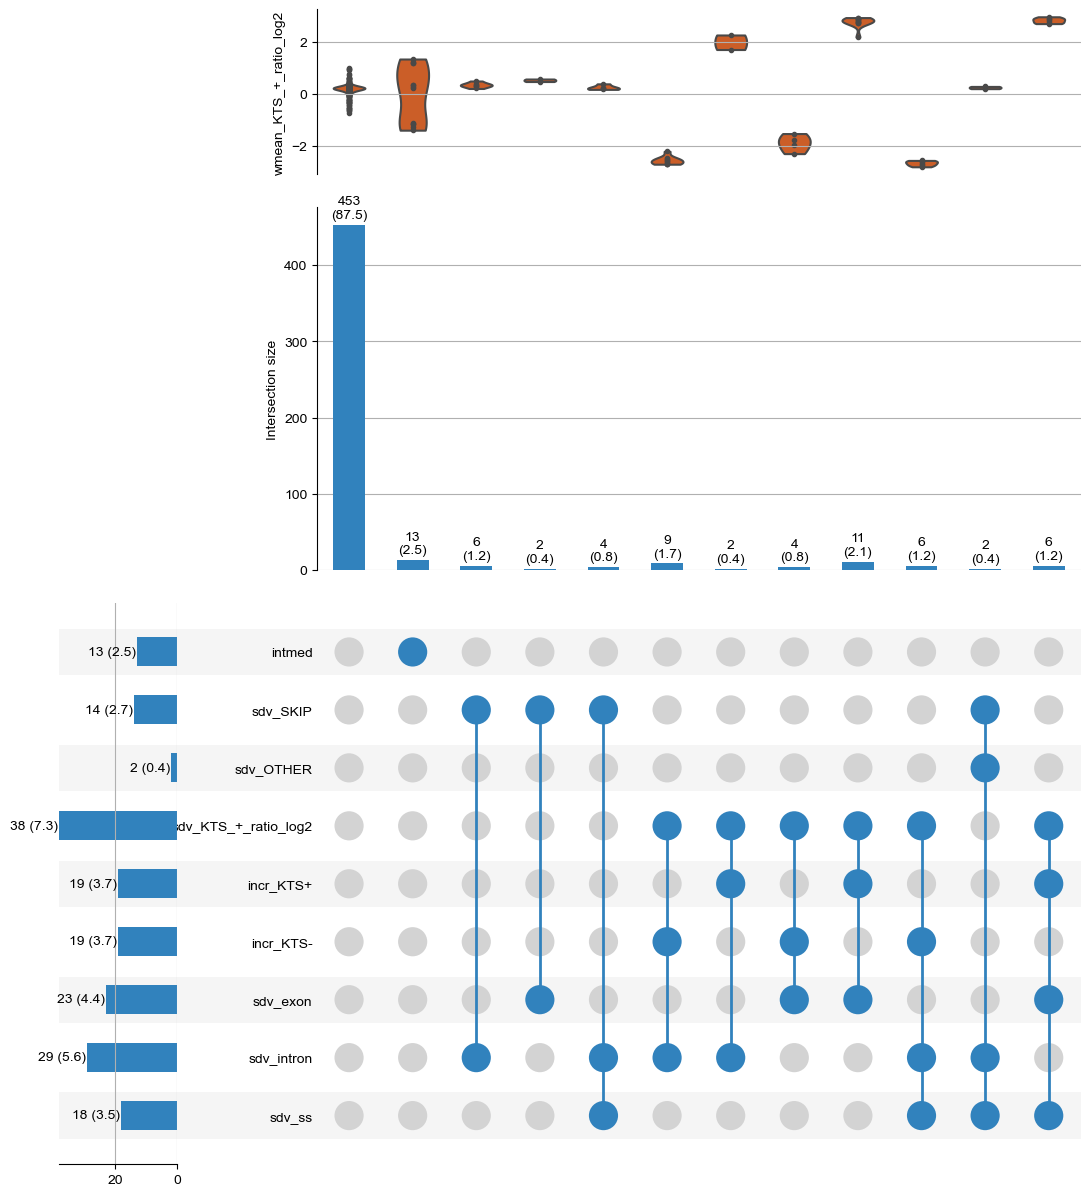

In [127]:
sp.upset_plot( byvartbl_wide, 
               [ 'intmed', 'sdv_SKIP', 'sdv_OTHER', 'sdv_KTS_+_ratio_log2', 'incr_KTS+', 'incr_KTS-', 'sdv_exon', 'sdv_intron', 'sdv_ss', ][ ::-1 ],
                ( 14, 14 ),
                [ 'wmean_KTS_+_ratio_log2' ],
                [ 'violin' ],
                [ light_colors[ 4 ] ],
                show_counts = '%d',
                show_percentages = '%.1f',
                facecolor = light_colors[ 0 ],
                element_size = 60,
               sort_categories_by = None,
               savefig = plot_out + 'sdv_upset.pdf'
              )

In [147]:
print( list( plt.get_cmap( 'Dark2' ) ) )

TypeError: 'ListedColormap' object is not iterable

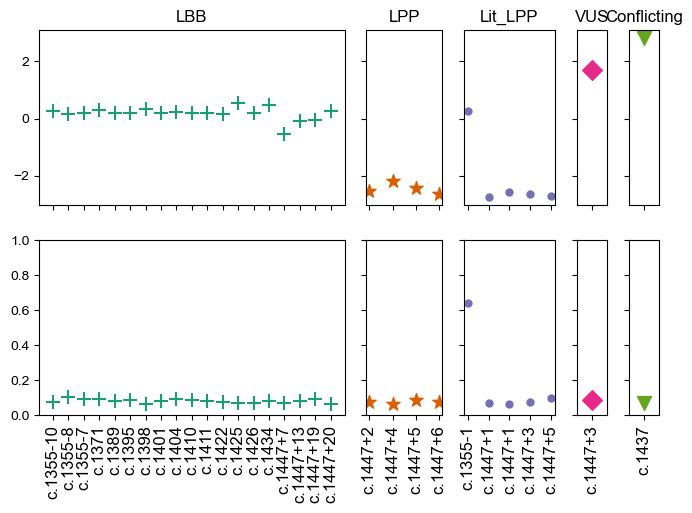

In [163]:
#moved this in from merge_lit_vars.2022-0721
np.random.seed( 721 )

tbv = byvartbl_wide.loc[ byvartbl_wide.lit_interp.notnull() ].copy()

fig,ax = plt.subplots( 2, len( tbv.lit_interp.unique() ),
                       gridspec_kw = { 'width_ratios' : [ len( tbv.loc[ tbv.lit_interp == l ] ) + 1 for l in tbv.lit_interp.unique() ] },
                       sharex = 'col',
                       sharey = 'row',
                       figsize = ( 8, 5 ) )

markers = [ '+', '*', '.', 'D', 'v' ]

colors = plt.get_cmap( 'Dark2' )

for i,interp in enumerate( tbv.lit_interp.unique() ):
    
    interp_df = tbv.loc[ tbv.lit_interp == interp ].sort_values( by = 'pos' ).reset_index().copy()
    
    ax[ 0 ][ i ].scatter( interp_df.index,
                     interp_df[ 'KTS_+_ratio_log2' ],
                     marker = markers[ i ],
                     color = colors( i ),
                     s = 100 )
    
    ax[ 1 ][ i ].scatter( interp_df.index,
                     interp_df.wmean_SKIP,
                     marker = markers[ i ],
                     color = colors( i ),
                     s = 100 )
    
    ax[ 0 ][ i ].set_title( interp )
    
    ax[ 1 ][ i ].set_ylim( ( 0, 1 ) )
    
    ax[ 1 ][ i ].set_xticks(  interp_df.index )
    
    ax[ 1 ][ i ].set_xticklabels( interp_df.hgvs_pos,
                                  fontsize=12,
                                  rotation='vertical' )
    
#ax[ 0 ][ 0 ].set_ylabel( 'KTS+ ratio log2' )
#ax[ 1 ][ 0 ].set_ylabel( 'SKIP PSI' )

#ax[ 1 ].set_xlabel( 'hg19 position' )

plt.show()

In [106]:
sp.barplot_per_repeat( byvartbl_wide_m.loc[ byvartbl_wide_m[ 'sdv' ] ],
                    'sdv_sum',
                    10,
                    ylim = ( 0, 100 ),
                    ylabel = 'Percent of splice disrupting variants',
                    xlabel = 'Number of samples',
                    #savefig = plot_out + 'sdv_by_samp.pdf',
                    color = light_colors[ 0 ]
                  )

0      0
1      0
2      0
3      0
4      0
      ..
513    0
514    0
515    0
516    0
517    0
Name: sdv_sum, Length: 518, dtype: int64